# Machine Learning Assessment

## Input

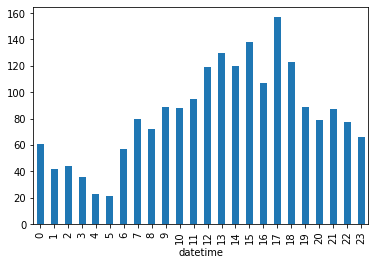

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   address                      2000 non-null   object        
 1   type                         2000 non-null   category      
 2   datetime                     2000 non-null   datetime64[ns]
 3   latitude                     1995 non-null   object        
 4   longitude                    1995 non-null   object        
 5   report_location              1995 non-null   object        
 6   incident_number              2000 non-null   object        
 7   :@computed_region_ru88_fbhk  1328 non-null   object        
 8   :@computed_region_kuhn_3gp2  1328 non-null   object        
 9   :@computed_region_q256_3sug  1995 non-null   object        
 10  :@computed_region_2day_rhn5  855 non-null    object        
 11  :@computed_region_cyqu_gs94  748 non-null  

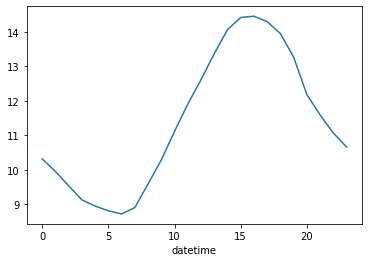

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170996 entries, 0 to 170995
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype                     
---  ------               --------------   -----                     
 0   dt                   170996 non-null  int64                     
 1   dt_iso               170996 non-null  object                    
 2   timezone             170996 non-null  int64                     
 3   city_name            170996 non-null  object                    
 4   lat                  170996 non-null  float64                   
 5   lon                  170996 non-null  float64                   
 6   temp                 170996 non-null  float64                   
 7   feels_like           170996 non-null  float64                   
 8   temp_min             170996 non-null  float64                   
 9   temp_max             170996 non-null  float64                   
 10  pressure             170996 non-null  int64 

In [65]:
#!/usr/bin/env python

# make sure to install these packages before running:
# pip install pandas
# pip install sodapy

import pandas as pd
from sodapy import Socrata
import matplotlib.pyplot as plt

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
# client = Socrata("data.seattle.gov", None)

# Example authenticated client (needed for non-public datasets):
client = Socrata("data.seattle.gov",
                 "UpBLPUNdDsriN0KhKXggi2zpR",
                 username="cmp0xff@gmail.com",
                 password="-ni0logIc")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("kzjm-xkqj", limit=2)
# results = client.get_all("kzjm-xkqj")

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

results_df['datetime'] = pd.to_datetime(results_df['datetime']).\
dt.tz_localize(tz='US/Pacific')

results_df['incident_number'].groupby(results_df['datetime'].dt.hour).count().plot(kind='bar')
plt.show()

results_df['type'] = results_df['type'].astype('category')

# print(results_df.info())
# print(results_df.head())
# print(results_df.tail())

# print(results_df['report_location'].tail())

weather_df = pd.read_csv('data/Seattle Weatherdata 2002 to 2020.csv')
weather_df['datetime'] = pd.to_datetime(weather_df['dt'], unit='s').\
dt.tz_localize(tz='UTC').\
dt.tz_convert('US/Pacific')

weather_df['temp'].groupby(weather_df['datetime'].dt.hour).mean().plot()
plt.show()

print(weather_df.info())
print(weather_df.head())
